# Imputing Time Series Missing Values

## Table of Contents

1. Introduction
2. Install & Import Packages
3. Generate Sales Data
4. Generate & Impute Missing Values
    4.1. Stationary
    4.2. Changing Mean
    4.3. Changing Variance
    4.4. Random Walk
    4.5. Seasonal
5. Compare
6. Resources

## 1. Introduction

Today, let's see how different missing value impute methods stack up for various types of time series. First, we'll generate imaginary monthly sales data (from a normal distribution) from January 2010 through December 2020 in 5 different types of series - stationary, changing mean, changing variance, random walk, and seasonal. Next, we'll generate sales with randomly removed values and fill them. To do so we'll create a mask to tag missing and filled values, generate random missing values (15%) using the boolean mask to replace those index values with null values, and fill the missing values using the following impute methods:

- Mean
- Median
- Most frequent (mode) 
- Last (forward fill): first preceding non-null value
- Next (back fill): next non-null value
- Last Next: mean of forward and back fill 
- KNN: mean of k nearest neighbors
- Iterative: predicts value using regression, done sequentially multiple times allowing prior imputed values as part of model
- Zeroes

Lastly, we'll see how the impute methods performed for each series based on their mean absolute error (MAE). Key findings according to MAE:
- Mean of forward and back fill performs best for changing mean, random walk, and seasonal series
- Back fill performs best for a changing variance series
- KNN performs best for a stationary series
- Mean and median aren't appropriate for changing mean and seasonal series, however they can be used for a stationary series
- Most frequent and zeroes performed poorly for all series

It's important to note that here we generate random missing values to test out how different imputation methods perform in different time series trends. In reality, when data includes missing values, it's important to understand the context and problem you're trying to solve, how the data is collected and study design, where the missing data came from (e.g., random, business holidays, non-response, etc.), and how we could expect missing values in the future. 

## 2. Install & Import Packages

In [152]:
import pandas as pd
import numpy as np
from datetime import datetime
from numpy.random import normal, seed
import re

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Autocorrelation
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Augmented Dickey Fuller (for random walk test)
from statsmodels.tsa.stattools import adfuller

# Filling missing values
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_style("darkgrid")
style.use('fivethirtyeight')
sns_c = sns.color_palette(palette='tab20')

## 3. Generate Sales Data

In [153]:
# Stationary
seed(232)
stationary = normal(loc=30000, scale=10000, size=132) # mean: 30000, st dev: 10000

# Changing Mean
seed(232)
t = np.arange(0,132)
changing_mean = (10000 * np.random.randn(132) + 0.0005*t**4) + 30000

# Changing variance
seed(232)
t = np.arange(0,132)
changing_variance = np.random.randn(132)*t*100 + 30000

# Random Walk
seed(232)
random_walk = np.empty(132)
season = np.concatenate([np.arange(0,33), np.arange(0,33),np.arange(0,33),np.arange(0,33)])
for i in range(1,132):
    random_walk[i] = random_walk[i-1] + np.random.randn()    
random_walk = 2500 * random_walk + 30000

# Seasonal
seasonal = random_walk + 2200*season

Text(0.5, 1.0, 'Seasonal')

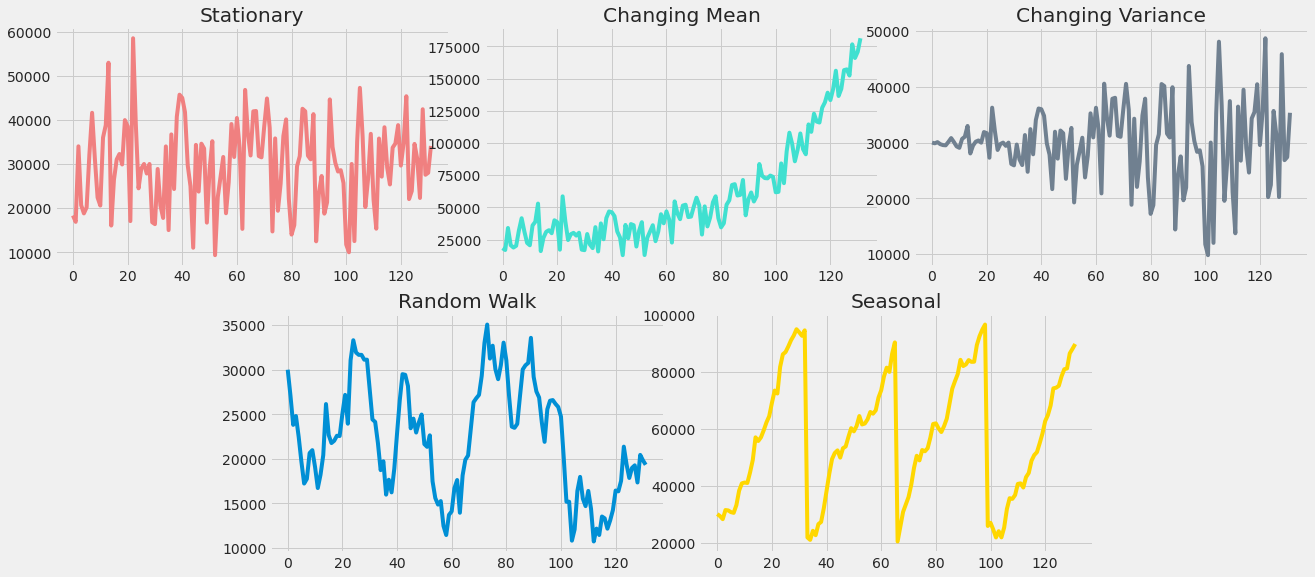

In [154]:
# Plot sales trends
plt.figure(figsize=(20,9))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

ax1.plot(stationary, color='lightcoral')
ax1.set_title('Stationary')

ax2.plot(changing_mean, color='turquoise')
ax2.set_title('Changing Mean')

ax3.plot(changing_variance, color='slategray')
ax3.set_title('Changing Variance')

ax4.plot(random_walk)
ax4.set_title('Random Walk')

ax5.plot(seasonal, color='gold')
ax5.set_title('Seasonal')

Let's doubl-check that the stationary series is, in fact, stationary using an acf plot and adfuller test. 

Text(0.5, 1.0, 'Autocorrelation')

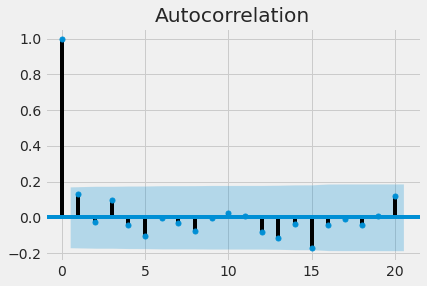

In [155]:
# Autocorrelation plot of stationary series
fig, ax = plt.subplots(figsize=(6,4))
plot_acf(stationary, lags=20, ax=ax)
ax.set_title ('Autocorrelation')

In [156]:
# Check that 1st order diff is stationary by running AD Fuller test.  
adf_results = adfuller(stationary)
print('The p-value of the ADF test is: ' + str(adf_results[1]))

The p-value of the ADF test is: 1.95124400605174e-17


There are no significant correlations in the plot and the p-value is tiny indicating the stationary series above is truly stationary.

In [157]:
# Create dataframe
sales = pd.DataFrame(dict(date = pd.date_range(start='2010-1-1', periods=132, freq='M'),
                       stationary = stationary,
                       changing_mean = changing_mean,
                       changing_variance = changing_variance,
                       random_walk = random_walk,
                       seasonal = seasonal))

# Check last1 few rows
sales.tail()

,date,stationary,changing_mean,changing_variance,random_walk,seasonal
127,2020-08-31,22304.006890,152376.327390,20226.088750,19263.126522,80863.126522
128,2020-09-30,42394.062382,176611.790382,45864.399849,17339.128244,81139.128244
129,2020-10-31,27557.458854,166018.899354,26849.121922,20437.643840,86437.643840
130,2020-11-30,28002.006148,170807.006148,27402.607992,19827.008554,88027.008554
131,2020-12-31,34082.678076,181332.638576,35348.308280,19327.510090,89727.510090


[Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Monthly Sales')]

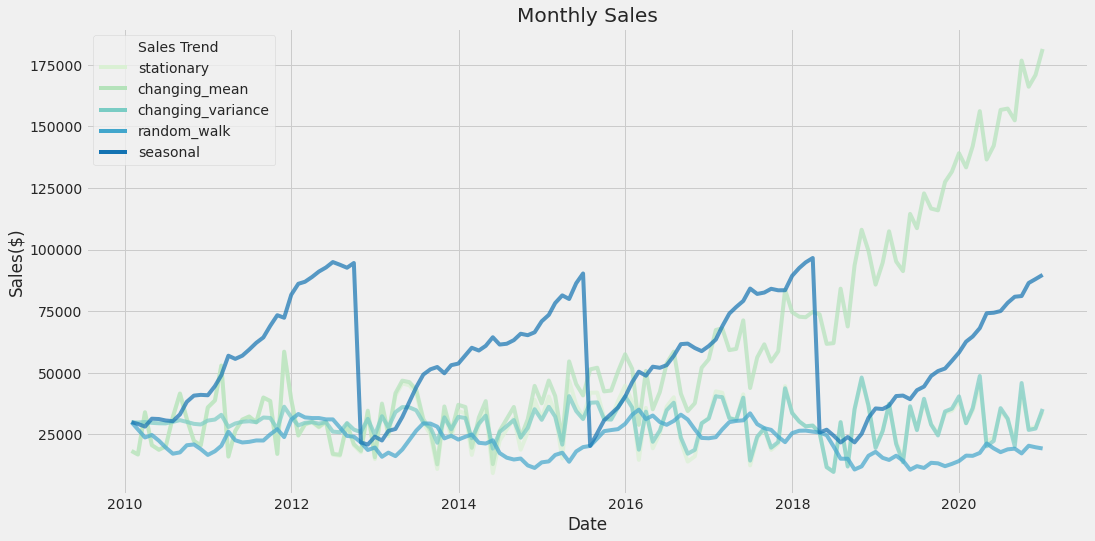

In [158]:
# Plot lines in one plot 

# Change from wide to long form with melt
sales_long = sales.melt(id_vars=['date'], var_name = 'Sales Trend', value_name='sales')
sales.head()

# Plot
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(x='date', 
             y='sales', 
             data=sales_long, 
             hue='Sales Trend',
             palette='GnBu',
             alpha=0.7,
             ax=ax)

ax.set(title='Monthly Sales', xlabel='Date', ylabel='Sales($)')

In [159]:
# Create month and year variables
sales = sales.assign(year = lambda x: x['date'].dt.year, 
                     month = lambda x: x['date'].dt.month).set_index('date')

sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2010-01-31 to 2020-12-31
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   stationary         132 non-null    float64
 1   changing_mean      132 non-null    float64
 2   changing_variance  132 non-null    float64
 3   random_walk        132 non-null    float64
 4   seasonal           132 non-null    float64
 5   year               132 non-null    int64  
 6   month              132 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 8.2 KB


## 4. Generate & Impute Missing Values

Let's create a new variable sales_na that includes sales values with randomly removed values. To do that, we'll:

- Create a mask to tag missing and filled values (na_mask)
- Generate random missing values (15%) using the boolean mask to replace those index values with NaN

Let's then fill missing values using various imputation methods and compare how the fill methods performed in each of the different trends. We'll apply the following fill methods: 

- Mean
- Median
- Most frequent (mode) 
- Last (forward fill): first preceding non-null value
- Next (back fill): next non-null value
- Last Next: mean of forward and back fill 
- KNN: mean of k nearest neighbors
- Iterative: predicts value using regression, done sequentially multiple times allowing prior imputed values as part of model
- Zeroes

Another method we don't use here, but can also compare in the future is [interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html).

Lastly, we'll see how the impute methods performed for each series based on their mean absolute error (MAE). 

## 4.1. Stationary

[Text(47.479375, 0.5, 'variable'),
 Text(0.5, -1.340000000000014, 'index'),
 Text(0.5, 1.0, 'Missing Values')]

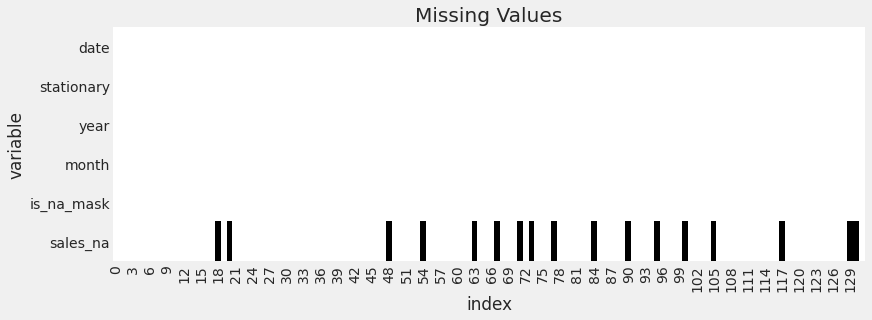

In [160]:
stationary = sales[['stationary', 'year','month']].reset_index()

# Generate missnig values (15%)
seed(232)
stationary['is_na_mask'] = np.random.binomial(n=1, p=0.15, size=stationary.shape[0]).astype('bool')*2000 #multiply by 2000 so lines visible in plot later
stationary = stationary.assign(sales_na = lambda x: np.where(x['is_na_mask'], np.nan, x['stationary'])) 

# Plot missing value index positions
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(data=stationary.isna().T, cmap='binary', cbar=False, ax=ax)
ax.set(title='Missing Values', xlabel='index', ylabel='variable')

[(0.0, 61391.62906240466),
 Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Monthly Sales (with missing values)')]

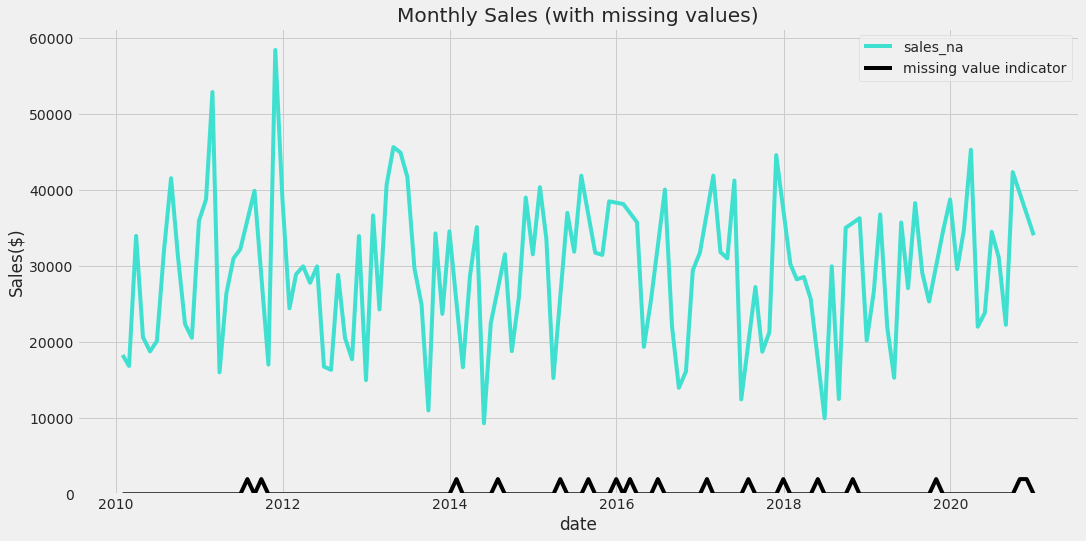

In [161]:
# Plot with missing values
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='sales_na', data=stationary, color='turquoise', label='sales_na', ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=stationary, color='black', label='missing value indicator',ax=ax)
ax.set(title='Monthly Sales (with missing values)', xlabel='date', ylabel='Sales($)', ylim=(0, None))

In [162]:
# Imput missing values using different methods
stationary = stationary.assign(sales_na_mean = lambda x: SimpleImputer(strategy='mean').fit_transform(x[['sales_na']]),
                               sales_na_median = lambda x: SimpleImputer(strategy='median').fit_transform(x[['sales_na']]),
                               sales_na_most_frequent = lambda x: SimpleImputer(strategy='most_frequent').fit_transform(x[['sales_na']]),
                               sales_na_last = lambda x: x['sales_na'].fillna(method='ffill'),
                               sales_na_next = lambda x: x['sales_na'].fillna(method='bfill'),
                               sales_na_last_next = lambda x: x[['sales_na_last', 'sales_na_next']].mean(axis=1),
                               sales_na_knn = lambda x: KNNImputer(n_neighbors=3, weights='distance').fit_transform(x[['sales_na', 'month', 'year']])[:, 0],
                               sales_na_iterative = lambda x: IterativeImputer().fit_transform(x[['sales_na', 'month', 'year']])[:, 0],
                               sales_na_zero = lambda x: SimpleImputer(fill_value=0.0, strategy='constant').fit_transform(x[['sales_na']])
                               )

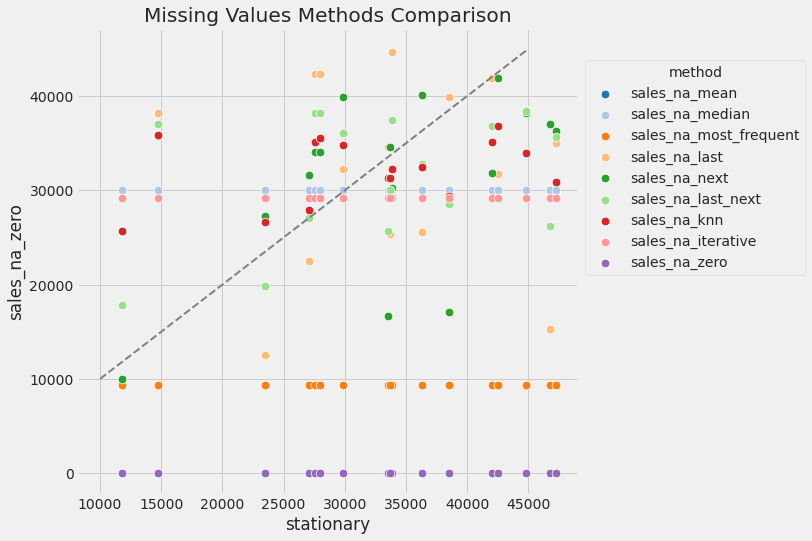

In [163]:
# Plot imputation methods
fig, ax = plt.subplots(figsize=(8, 8))

for i, col in enumerate(stationary.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='stationary',
        y=col,
        data=stationary.query('sales_na.isnull().values'),
        color=sns_c[i],
        label=col,
        s=75,
        ax=ax
    )
    
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.7))
ax.set(title='Missing Values Methods Comparison')
ax.plot([10000, 45000], [10000,45000], ls="--", lw=2, c='0.5')
# ax.axline(xy1=(10000, 10000), slope=1, color='gray', linestyle='--') # For some reason this wasn't working so I used ax.plot above

[(0.0, 61391.62906240466),
 Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Missing Values Methods Comparison')]

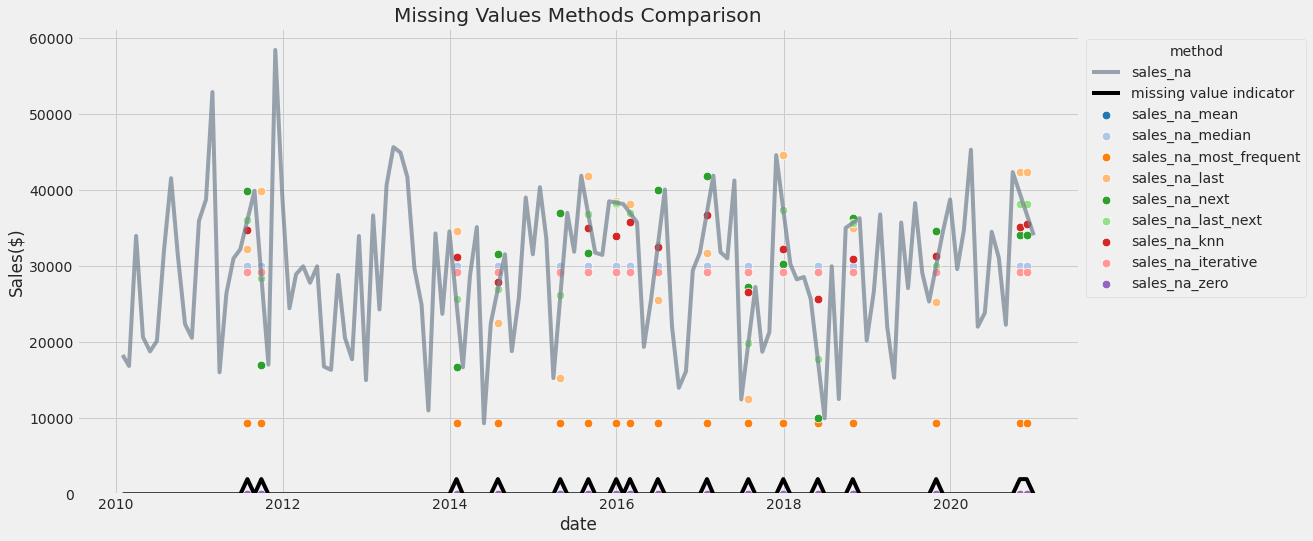

In [164]:
# Plot imputed missing values with true values
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(x='date', y='sales_na', data=stationary, color='slategray', label='sales_na', alpha=0.7, ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=stationary, color='black', label='missing value indicator',ax=ax)

for i, col in enumerate(stationary.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='date',
        y=col,
        data=stationary.query('sales_na.isnull().values'),
        color=sns_c[i],
        label=col,
        s=75,
        ax=ax
    )
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.7))
ax.set(title='Missing Values Methods Comparison', xlabel='date', ylabel='Sales($)', ylim=(0, None))

[Text(0, 0.5, ''),
 Text(0.5, 0, 'method'),
 Text(0.5, 1.0, 'Imputation Methods MAE')]

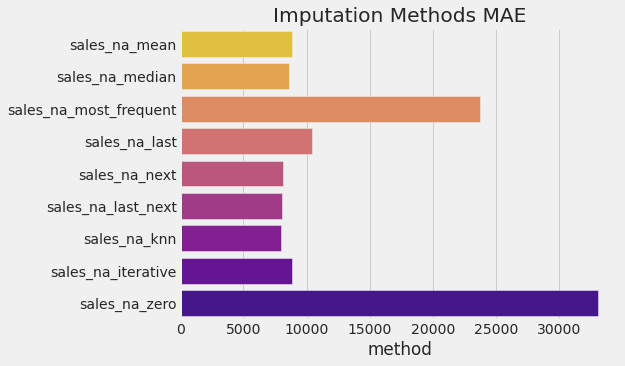

In [165]:
# Calculate and plot mean absolute error (MAE) by method
mae_dict = {}

for col in stationary.filter(regex='sales_na_').columns:
    mae_dict[col] = mean_absolute_error(
        y_true=stationary.query('sales_na.isnull().values')['stationary'], 
        y_pred=stationary.query('sales_na.isnull().values')[col]
    )

fig, ax = plt.subplots(figsize=(7, 5))

pd.DataFrame.from_dict(mae_dict, orient='index', columns=['mae']) \
            .reset_index(drop=False) \
            .pipe((sns.barplot, 'data'),
                   y='index', 
                   x='mae',
                   palette='plasma_r',
                   ax=ax
             )
ax.set(title='Imputation Methods MAE', xlabel='method', ylabel='')

In [166]:
# Sorted MAE values
stationary_mae = pd.DataFrame.from_dict(mae_dict, orient='index', columns=['stationary']).sort_values('stationary')
stationary_mae

,stationary
sales_na_knn,7979.524343
sales_na_last_next,8067.847800
sales_na_next,8142.534259
sales_na_median,8639.454024
sales_na_mean,8856.469143
sales_na_iterative,8856.469394
sales_na_last,10451.452628
sales_na_most_frequent,23689.091177
sales_na_zero,33039.780151


For a stationary series, knn performs the best. Mean of last and next, next, median, mean, and iterative also have fairly similar performance. 

## 4.2. Changing Mean

[Text(47.479375, 0.5, 'variable'),
 Text(0.5, -1.340000000000014, 'index'),
 Text(0.5, 1.0, 'Missing Values')]

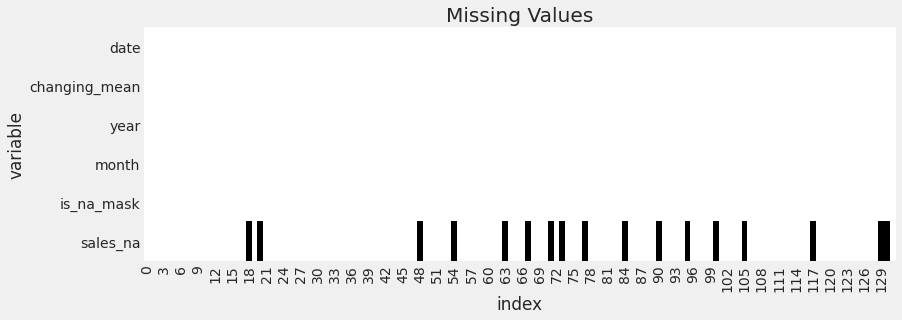

In [167]:
changing_mean = sales[['changing_mean', 'year','month']].reset_index()

# Generate missnig values (15%)
seed(232)
changing_mean['is_na_mask'] = np.random.binomial(n=1, p=0.15, size=changing_mean.shape[0]).astype('bool')*2000 #multiply by 2000 so lines visible in plot later
changing_mean = changing_mean.assign(sales_na = lambda x: np.where(x['is_na_mask'], np.nan, x['changing_mean'])) 

# Plot missing value index positions
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(data=changing_mean.isna().T, cmap='binary', cbar=False, ax=ax)
ax.set(title='Missing Values', xlabel='index', ylabel='variable')

[(0.0, 190399.27050507627),
 Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Monthly Sales (with missing values)')]

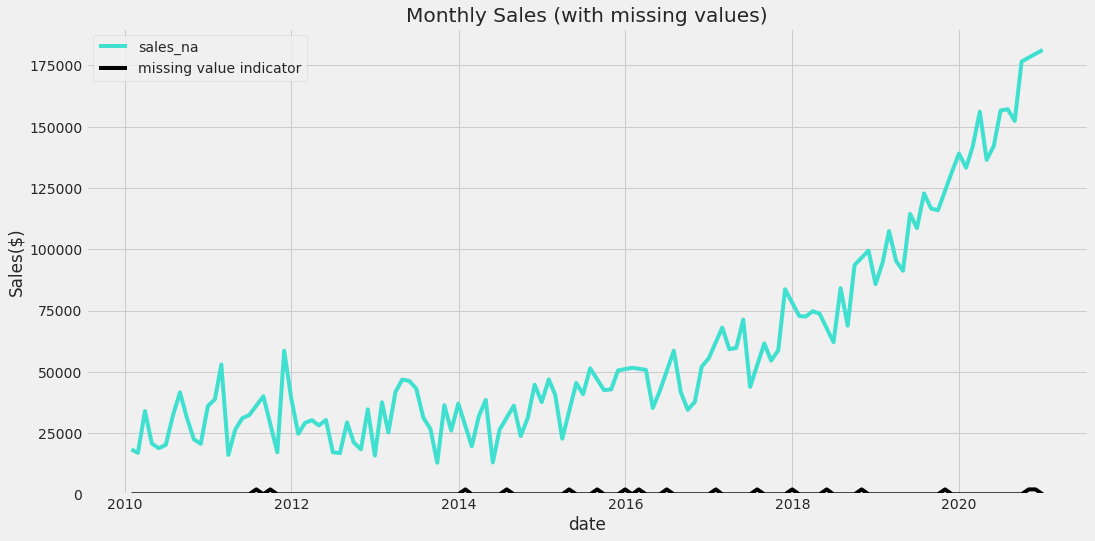

In [168]:
# Plot with missing values
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='sales_na', data=changing_mean, color='turquoise', label='sales_na', ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=changing_mean, color='black', label='missing value indicator',ax=ax)
ax.set(title='Monthly Sales (with missing values)', xlabel='date', ylabel='Sales($)', ylim=(0, None))

In [169]:
# Impute missing values using different methods
changing_mean = changing_mean.assign(sales_na_mean = lambda x: SimpleImputer(strategy='mean').fit_transform(x[['sales_na']]),
                               sales_na_median = lambda x: SimpleImputer(strategy='median').fit_transform(x[['sales_na']]),
                               sales_na_most_frequent = lambda x: SimpleImputer(strategy='most_frequent').fit_transform(x[['sales_na']]),
                               sales_na_last = lambda x: x['sales_na'].fillna(method='ffill'),
                               sales_na_next = lambda x: x['sales_na'].fillna(method='bfill'),
                               sales_na_last_next = lambda x: x[['sales_na_last', 'sales_na_next']].mean(axis=1),
                               sales_na_knn = lambda x: KNNImputer(n_neighbors=3, weights='distance').fit_transform(x[['sales_na', 'month', 'year']])[:, 0],
                               sales_na_iterative = lambda x: IterativeImputer().fit_transform(x[['sales_na', 'month', 'year']])[:, 0],
                               sales_na_zero = lambda x: SimpleImputer(fill_value=0.0, strategy='constant').fit_transform(x[['sales_na']])
                               )

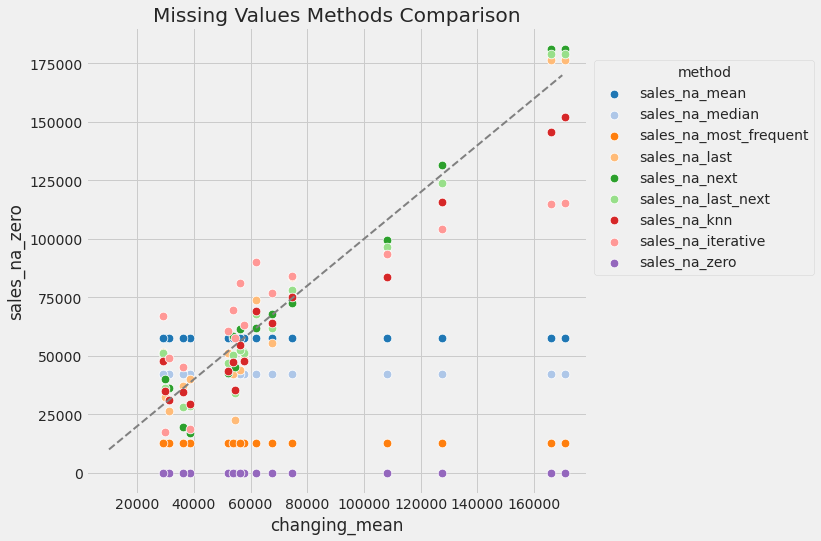

In [170]:
# Plot imputation methods 
fig, ax = plt.subplots(figsize=(8, 8))

for i, col in enumerate(changing_mean.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='changing_mean',
        y=col,
        data=changing_mean.query('sales_na.isnull().values'),
        color=sns_c[i],
        label=col,
        s=75,
        ax=ax
    )
    
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.7))
ax.set(title='Missing Values Methods Comparison')
ax.plot([10000, 170000], [10000,170000], ls="--", lw=2, c='0.5')
# ax.axline(xy1=(10000, 10000), slope=1, color='gray', linestyle='--') # For some reason this wasn't working so I used ax.plot above

[(0.0, 190399.27050507627),
 Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Missing Values Methods Comparison')]

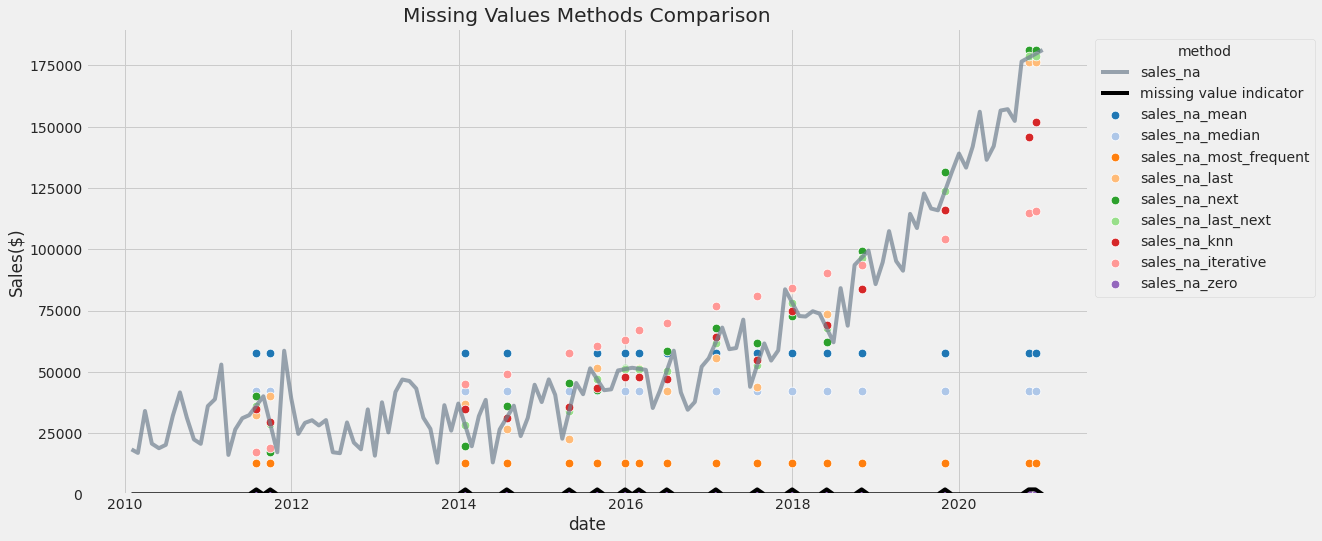

In [171]:
# Plot imputed missing values with true values
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(x='date', y='sales_na', data=changing_mean, color='slategray', label='sales_na', alpha=0.7, ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=changing_mean, color='black', label='missing value indicator',ax=ax)

for i, col in enumerate(changing_mean.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='date',
        y=col,
        data=changing_mean.query('sales_na.isnull().values'),
        color=sns_c[i],
        label=col,
        s=75,
        ax=ax
    )
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.7))
ax.set(title='Missing Values Methods Comparison', xlabel='date', ylabel='Sales($)', ylim=(0, None))

[Text(0, 0.5, ''),
 Text(0.5, 0, 'method'),
 Text(0.5, 1.0, 'Imputation Methods MAE')]

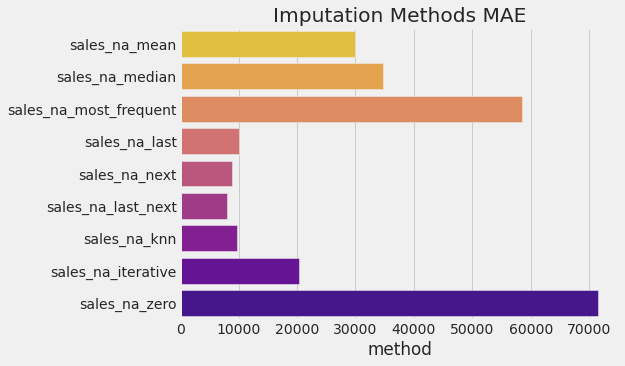

In [172]:
# Calculate and plot mean absolute error (MAE) by method
mae_dict = {}

for col in changing_mean.filter(regex='sales_na_').columns:
    mae_dict[col] = mean_absolute_error(
        y_true=changing_mean.query('sales_na.isnull().values')['changing_mean'], 
        y_pred=changing_mean.query('sales_na.isnull().values')[col]
    )

fig, ax = plt.subplots(figsize=(7, 5))

pd.DataFrame.from_dict(mae_dict, orient='index', columns=['mae']) \
            .reset_index(drop=False) \
            .pipe((sns.barplot, 'data'),
                   y='index', 
                   x='mae',
                   palette='plasma_r',
                   ax=ax
             )
ax.set(title='Imputation Methods MAE', xlabel='method', ylabel='')

In [173]:
# Sorted MAE values
changing_mean_mae = pd.DataFrame.from_dict(mae_dict, orient='index', columns=['changing_mean']).sort_values('changing_mean')
changing_mean_mae

,changing_mean
sales_na_last_next,8073.003318
sales_na_next,8874.189028
sales_na_knn,9751.271532
sales_na_last,10070.920510
sales_na_iterative,20409.520653
sales_na_mean,29988.505041
sales_na_median,34698.625628
sales_na_most_frequent,58584.689299
sales_na_zero,71488.706062


For changing mean, the mean of last and next performs the best. Unlike in the stationary series, median and mean are poor methods to fill missing values here as the mean is constantly increasing.

## 4.3. Changing Variance

[Text(47.479375, 0.5, 'variable'),
 Text(0.5, -1.340000000000014, 'index'),
 Text(0.5, 1.0, 'Missing Values')]

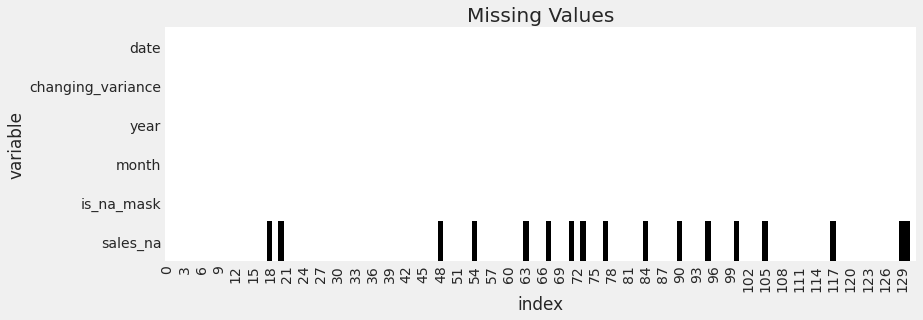

In [174]:
changing_variance = sales[['changing_variance', 'year','month']].reset_index()

# Generate missnig values (15%)
seed(232)
changing_variance['is_na_mask'] = np.random.binomial(n=1, p=0.15, size=changing_variance.shape[0]).astype('bool')*2000 #multiply by 2000 so lines visible in plot later
changing_variance = changing_variance.assign(sales_na = lambda x: np.where(x['is_na_mask'], np.nan, x['changing_variance'])) 

# Plot missing value index positions
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(data=changing_variance.isna().T, cmap='binary', cbar=False, ax=ax)
ax.set(title='Missing Values', xlabel='index', ylabel='variable')

[(0.0, 51151.08300524732),
 Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Monthly Sales (with missing values)')]

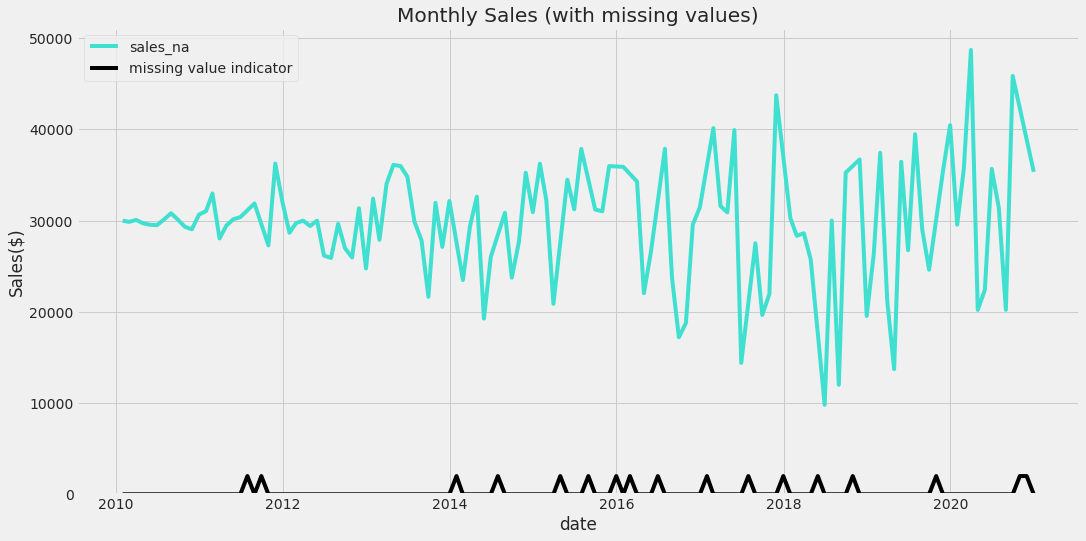

In [175]:
# Plot with missing values
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='sales_na', data=changing_variance, color='turquoise', label='sales_na', ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=changing_variance, color='black', label='missing value indicator',ax=ax)
ax.set(title='Monthly Sales (with missing values)', xlabel='date', ylabel='Sales($)', ylim=(0, None))

In [176]:
# Impute missing values using different methods
changing_variance = changing_variance.assign(sales_na_mean = lambda x: SimpleImputer(strategy='mean').fit_transform(x[['sales_na']]),
                               sales_na_median = lambda x: SimpleImputer(strategy='median').fit_transform(x[['sales_na']]),
                               sales_na_most_frequent = lambda x: SimpleImputer(strategy='most_frequent').fit_transform(x[['sales_na']]),
                               sales_na_last = lambda x: x['sales_na'].fillna(method='ffill'),
                               sales_na_next = lambda x: x['sales_na'].fillna(method='bfill'),
                               sales_na_last_next = lambda x: x[['sales_na_last', 'sales_na_next']].mean(axis=1),
                               sales_na_knn = lambda x: KNNImputer(n_neighbors=3, weights='distance').fit_transform(x[['sales_na', 'month', 'year']])[:, 0],
                               sales_na_iterative = lambda x: IterativeImputer().fit_transform(x[['sales_na', 'month', 'year']])[:, 0],
                               sales_na_zero = lambda x: SimpleImputer(fill_value=0.0, strategy='constant').fit_transform(x[['sales_na']])
                               )

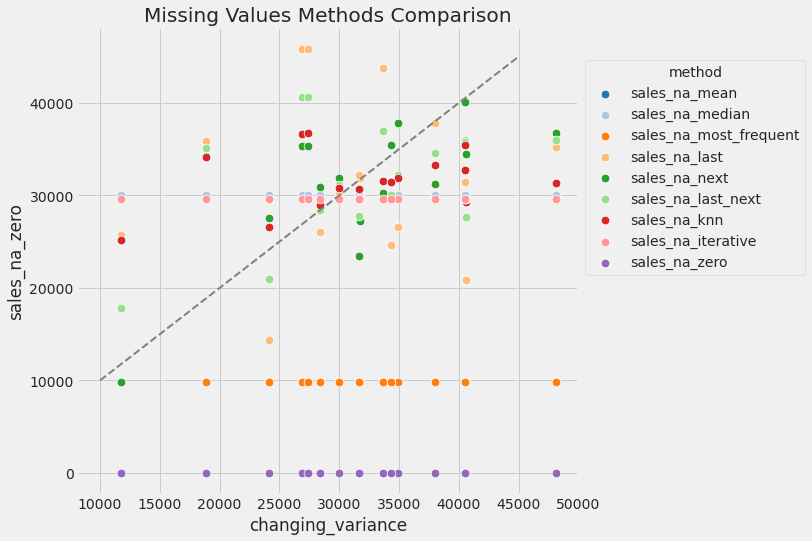

In [177]:
# Plot imputation methods 
fig, ax = plt.subplots(figsize=(8, 8))

for i, col in enumerate(changing_variance.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='changing_variance',
        y=col,
        data=changing_variance.query('sales_na.isnull().values'),
        color=sns_c[i],
        label=col,
        s=75,
        ax=ax
    )
    
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.7))
ax.set(title='Missing Values Methods Comparison')
ax.plot([10000, 45000], [10000,45000], ls="--", lw=2, c='0.5')
# ax.axline(xy1=(10000, 10000), slope=1, color='gray', linestyle='--') # For some reason this wasn't working so I used ax.plot above

[(0.0, 51151.08300524732),
 Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Missing Values Methods Comparison')]

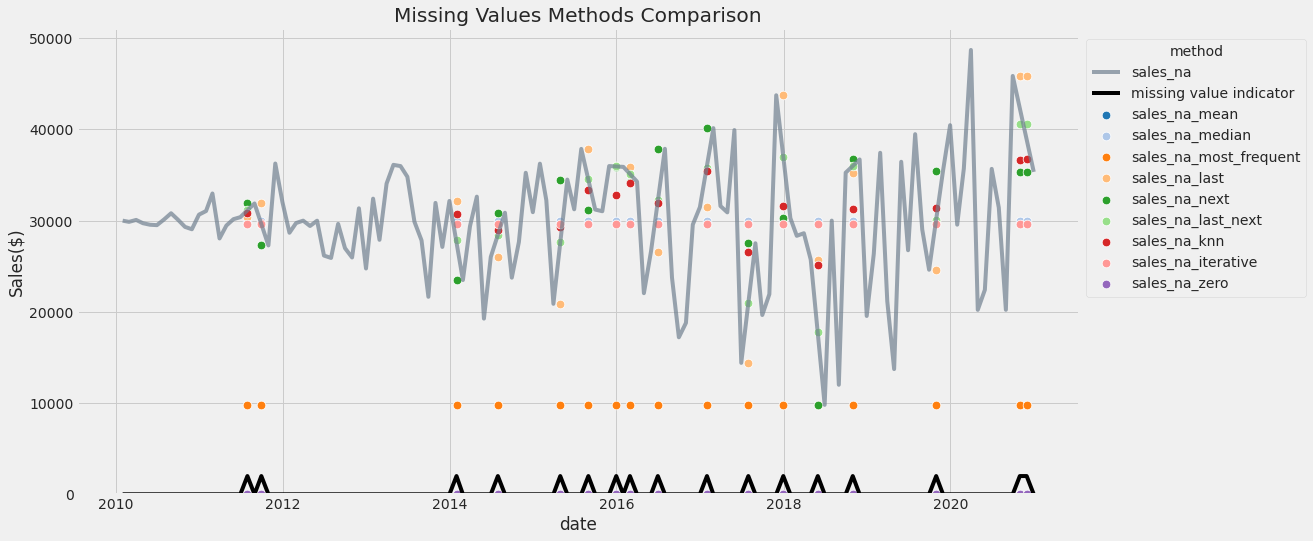

In [178]:
# Plot imputed missing values with true values
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(x='date', y='sales_na', data=changing_variance, color='slategray', label='sales_na', alpha=0.7, ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=changing_variance, color='black', label='missing value indicator',ax=ax)

for i, col in enumerate(changing_variance.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='date',
        y=col,
        data=changing_variance.query('sales_na.isnull().values'),
        color=sns_c[i],
        label=col,
        s=75,
        ax=ax
    )
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.7))
ax.set(title='Missing Values Methods Comparison', xlabel='date', ylabel='Sales($)', ylim=(0, None))

[Text(0, 0.5, ''),
 Text(0.5, 0, 'method'),
 Text(0.5, 1.0, 'Imputation Methods MAE')]

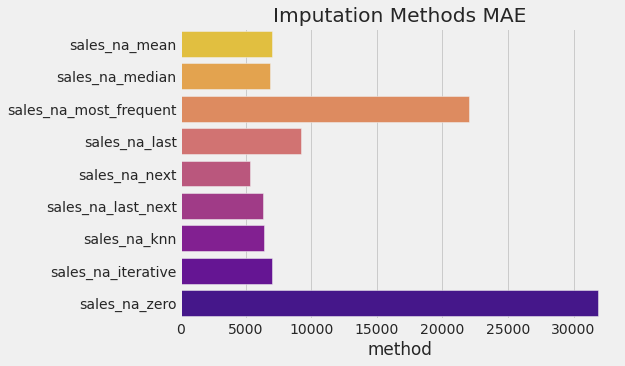

In [179]:
# Calculate and plot mean absolute error (MAE) by method
mae_dict = {}

for col in changing_variance.filter(regex='sales_na_').columns:
    mae_dict[col] = mean_absolute_error(
        y_true=changing_variance.query('sales_na.isnull().values')['changing_variance'], 
        y_pred=changing_variance.query('sales_na.isnull().values')[col]
    )

fig, ax = plt.subplots(figsize=(7, 5))

pd.DataFrame.from_dict(mae_dict, orient='index', columns=['mae']) \
            .reset_index(drop=False) \
            .pipe((sns.barplot, 'data'),
                   y='index', 
                   x='mae',
                   palette='plasma_r',
                   ax=ax
             )
ax.set(title='Imputation Methods MAE', xlabel='method', ylabel='')

In [180]:
# Sorted MAE values
changing_variance_mae = pd.DataFrame.from_dict(mae_dict, orient='index', columns=['changing_variance']).sort_values('changing_variance')
changing_variance_mae

,changing_variance
sales_na_next,5355.135666
sales_na_last_next,6327.861908
sales_na_knn,6355.136621
sales_na_median,6862.983317
sales_na_mean,6964.791178
sales_na_iterative,6964.791214
sales_na_last,9175.533472
sales_na_most_frequent,22036.951546
sales_na_zero,31843.355245


For changing variance, next (back fill) performs the best. Mean, median, and iterative imputations perform similarly.

## 4.4. Random Walk

[Text(47.479375, 0.5, 'variable'),
 Text(0.5, -1.340000000000014, 'index'),
 Text(0.5, 1.0, 'Missing Values')]

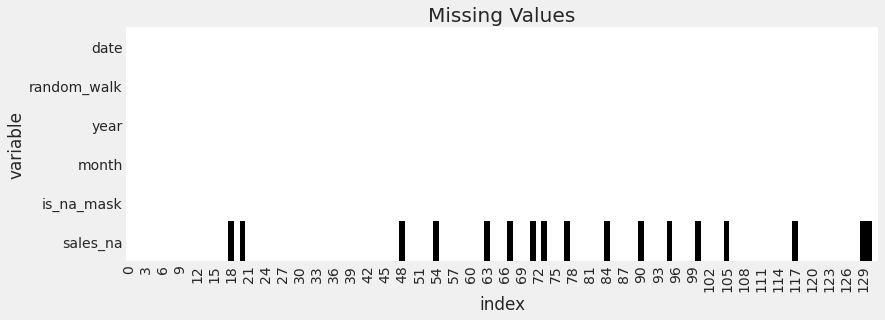

In [181]:
random_walk = sales[['random_walk', 'year','month']].reset_index()

# Generate missnig values (15%)
seed(232)
random_walk['is_na_mask'] = np.random.binomial(n=1, p=0.15, size=random_walk.shape[0]).astype('bool')*2000 #multiply by 2000 so lines visible in plot later
random_walk = random_walk.assign(sales_na = lambda x: np.where(x['is_na_mask'], np.nan, x['random_walk'])) 

# Plot missing value index positions
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(data=random_walk.isna().T, cmap='binary', cbar=False, ax=ax)
ax.set(title='Missing Values', xlabel='index', ylabel='variable')

[(0.0, 35256.72191201032),
 Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Monthly Sales (with missing values)')]

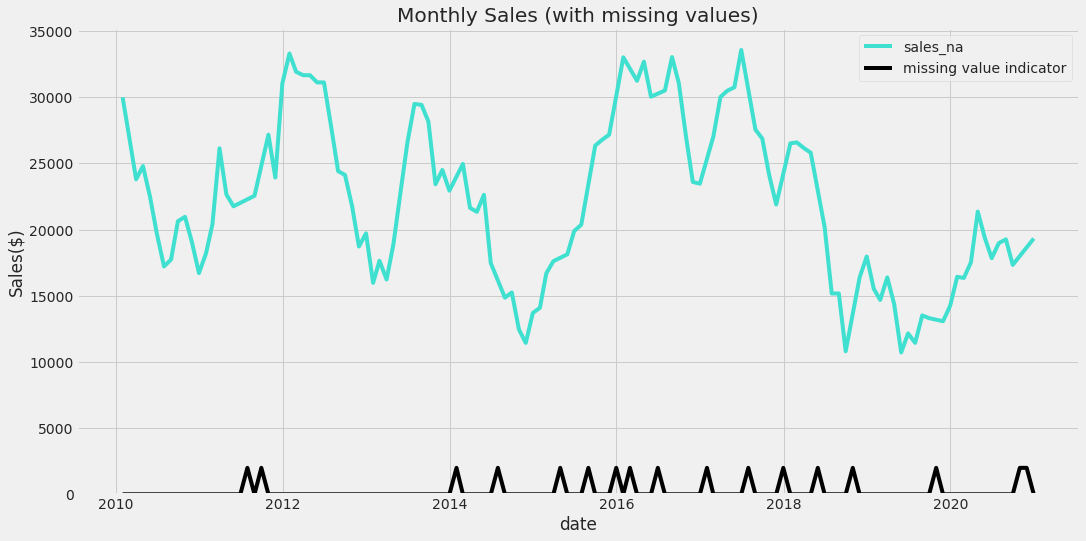

In [182]:
# Plot with missing values
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='sales_na', data=random_walk, color='turquoise', label='sales_na', ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=random_walk, color='black', label='missing value indicator',ax=ax)
ax.set(title='Monthly Sales (with missing values)', xlabel='date', ylabel='Sales($)', ylim=(0, None))

In [183]:
# Impute missing values using different methods
random_walk = random_walk.assign(sales_na_mean = lambda x: SimpleImputer(strategy='mean').fit_transform(x[['sales_na']]),
                               sales_na_median = lambda x: SimpleImputer(strategy='median').fit_transform(x[['sales_na']]),
                               sales_na_most_frequent = lambda x: SimpleImputer(strategy='most_frequent').fit_transform(x[['sales_na']]),
                               sales_na_last = lambda x: x['sales_na'].fillna(method='ffill'),
                               sales_na_next = lambda x: x['sales_na'].fillna(method='bfill'),
                               sales_na_last_next = lambda x: x[['sales_na_last', 'sales_na_next']].mean(axis=1),
                               sales_na_knn = lambda x: KNNImputer(n_neighbors=3, weights='distance').fit_transform(x[['sales_na', 'month', 'year']])[:, 0],
                               sales_na_iterative = lambda x: IterativeImputer().fit_transform(x[['sales_na', 'month', 'year']])[:, 0],
                               sales_na_zero = lambda x: SimpleImputer(fill_value=0.0, strategy='constant').fit_transform(x[['sales_na']])
                               )

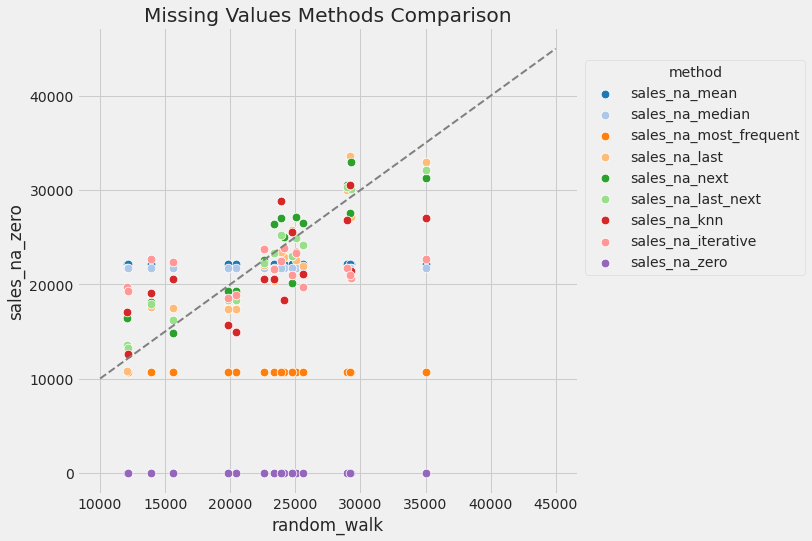

In [184]:
# Plot imputation methods 
fig, ax = plt.subplots(figsize=(8, 8))

for i, col in enumerate(random_walk.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='random_walk',
        y=col,
        data=random_walk.query('sales_na.isnull().values'),
        color=sns_c[i],
        label=col,
        s=75,
        ax=ax
    )
    
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.7))
ax.set(title='Missing Values Methods Comparison')
ax.plot([10000, 45000], [10000,45000], ls="--", lw=2, c='0.5')
# ax.axline(xy1=(10000, 10000), slope=1, color='gray', linestyle='--') # For some reason this wasn't working so I used ax.plot above

[(0.0, 35256.72191201032),
 Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Missing Values Methods Comparison')]

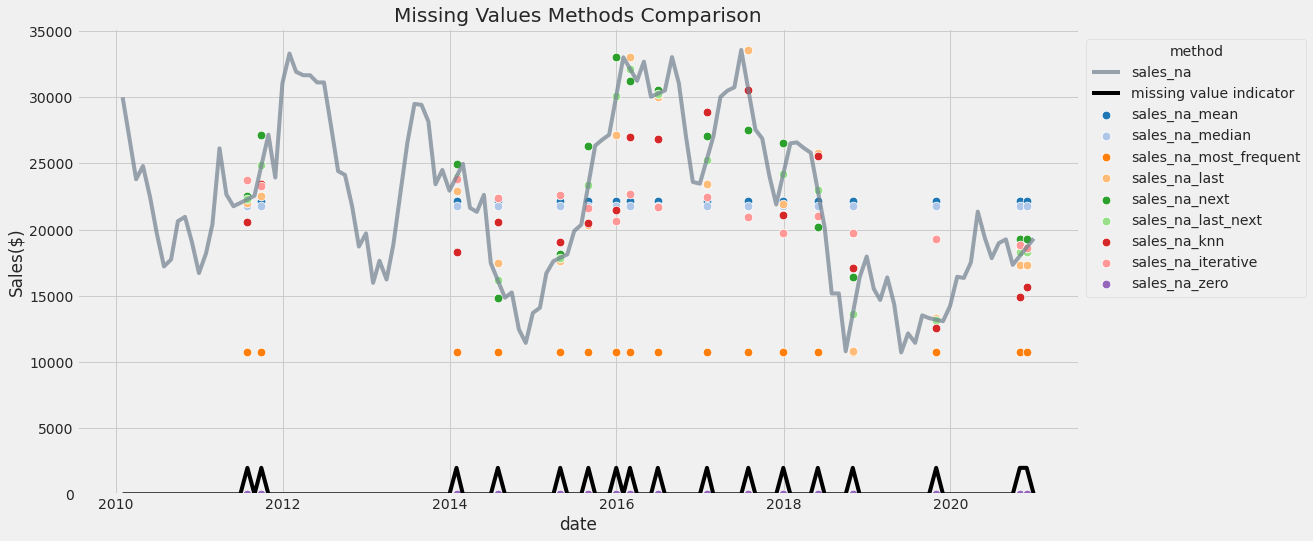

In [185]:
# Plot imputed missing values with true values
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(x='date', y='sales_na', data=random_walk, color='slategray', label='sales_na', alpha=0.7, ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=random_walk, color='black', label='missing value indicator',ax=ax)

for i, col in enumerate(random_walk.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='date',
        y=col,
        data=random_walk.query('sales_na.isnull().values'),
        color=sns_c[i],
        label=col,
        s=75,
        ax=ax
    )
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.7))
ax.set(title='Missing Values Methods Comparison', xlabel='date', ylabel='Sales($)', ylim=(0, None))

[Text(0, 0.5, ''),
 Text(0.5, 0, 'method'),
 Text(0.5, 1.0, 'Imputation Methods MAE')]

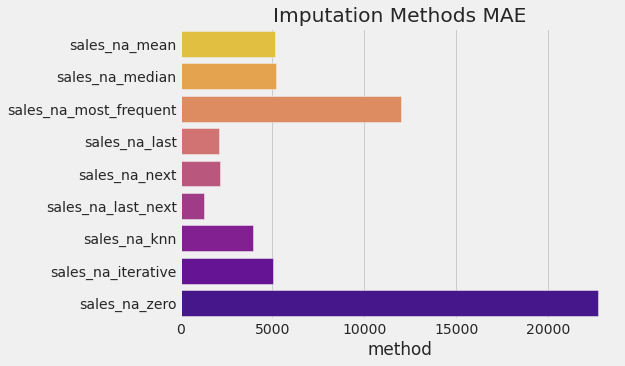

In [186]:
# Calculate and plot mean absolute error (MAE) by method
mae_dict = {}

for col in random_walk.filter(regex='sales_na_').columns:
    mae_dict[col] = mean_absolute_error(
        y_true=random_walk.query('sales_na.isnull().values')['random_walk'], 
        y_pred=random_walk.query('sales_na.isnull().values')[col]
    )

fig, ax = plt.subplots(figsize=(7, 5))

pd.DataFrame.from_dict(mae_dict, orient='index', columns=['mae']) \
            .reset_index(drop=False) \
            .pipe((sns.barplot, 'data'),
                   y='index', 
                   x='mae',
                   palette='plasma_r',
                   ax=ax
             )
ax.set(title='Imputation Methods MAE', xlabel='method', ylabel='')

In [187]:
# Sorted MAE values
random_walk_mae = pd.DataFrame.from_dict(mae_dict, orient='index', columns=['random_walk']).sort_values('random_walk')
random_walk_mae

,random_walk
sales_na_last_next,1303.162848
sales_na_last,2093.794987
sales_na_next,2188.969666
sales_na_knn,3940.218309
sales_na_iterative,5033.348815
sales_na_mean,5125.297038
sales_na_median,5227.207290
sales_na_most_frequent,11976.596012
sales_na_zero,22695.659755


For random walk, the mean of forward and back fill performs best. Here again, median and mean are poor methods to fill missing values as the mean is constantly increasing.

## 4.5. Seasonal

[Text(47.479375, 0.5, 'variable'),
 Text(0.5, -1.340000000000014, 'index'),
 Text(0.5, 1.0, 'Missing Values')]

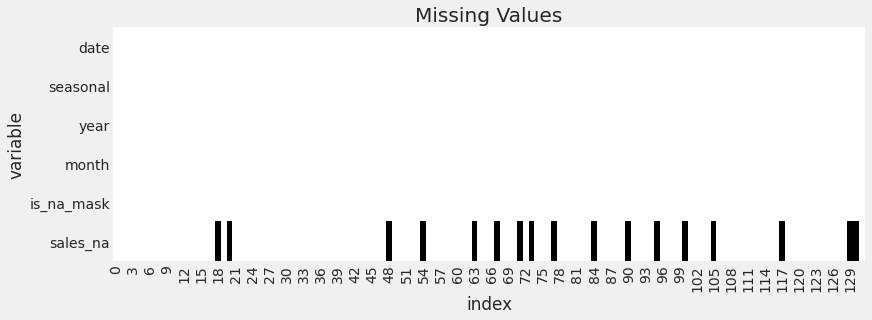

In [188]:
seasonal = sales[['seasonal', 'year','month']].reset_index()

# Generate missnig values (15%)
seed(232)
seasonal['is_na_mask'] = np.random.binomial(n=1, p=0.15, size=seasonal.shape[0]).astype('bool')*2000 #multiply by 2000 so lines visible in plot later
seasonal = seasonal.assign(sales_na = lambda x: np.where(x['is_na_mask'], np.nan, x['seasonal'])) 

# Plot missing value index positions
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(data=seasonal.isna().T, cmap='binary', cbar=False, ax=ax)
ax.set(title='Missing Values', xlabel='index', ylabel='variable')

[(0.0, 101392.53839345077),
 Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Monthly Sales (with missing values)')]

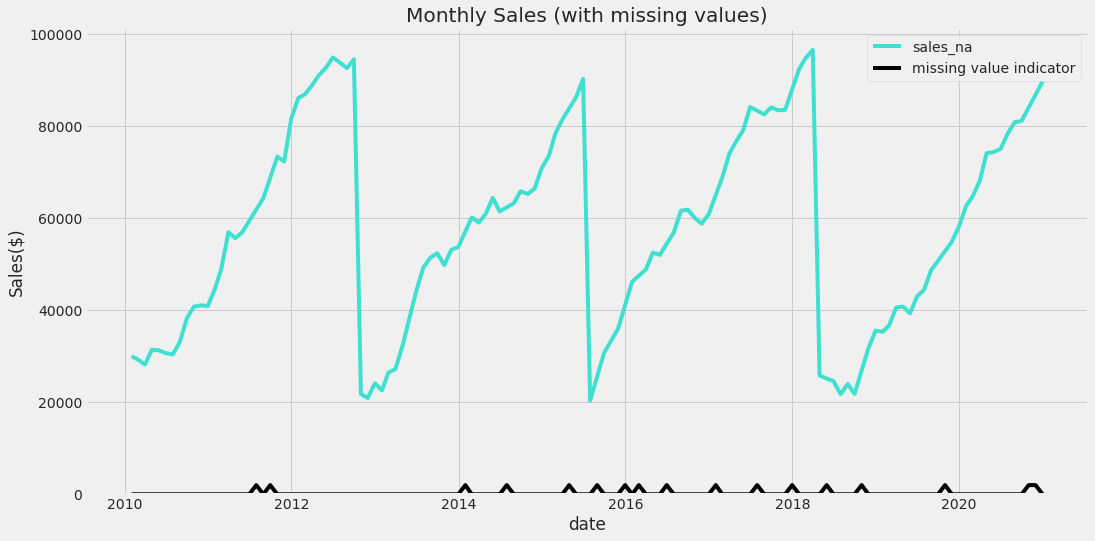

In [189]:
# Plot with missing values
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='sales_na', data=seasonal, color='turquoise', label='sales_na', ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=seasonal, color='black', label='missing value indicator',ax=ax)
ax.set(title='Monthly Sales (with missing values)', xlabel='date', ylabel='Sales($)', ylim=(0, None))

In [190]:
# Impute missing values using different methods
seasonal = seasonal.assign(sales_na_mean = lambda x: SimpleImputer(strategy='mean').fit_transform(x[['sales_na']]),
                               sales_na_median = lambda x: SimpleImputer(strategy='median').fit_transform(x[['sales_na']]),
                               sales_na_most_frequent = lambda x: SimpleImputer(strategy='most_frequent').fit_transform(x[['sales_na']]),
                               sales_na_last = lambda x: x['sales_na'].fillna(method='ffill'),
                               sales_na_next = lambda x: x['sales_na'].fillna(method='bfill'),
                               sales_na_last_next = lambda x: x[['sales_na_last', 'sales_na_next']].mean(axis=1),
                               sales_na_knn = lambda x: KNNImputer(n_neighbors=3, weights='distance').fit_transform(x[['sales_na', 'month', 'year']])[:, 0],
                               sales_na_iterative = lambda x: IterativeImputer().fit_transform(x[['sales_na', 'month', 'year']])[:, 0],
                               sales_na_zero = lambda x: SimpleImputer(fill_value=0.0, strategy='constant').fit_transform(x[['sales_na']])
                               )

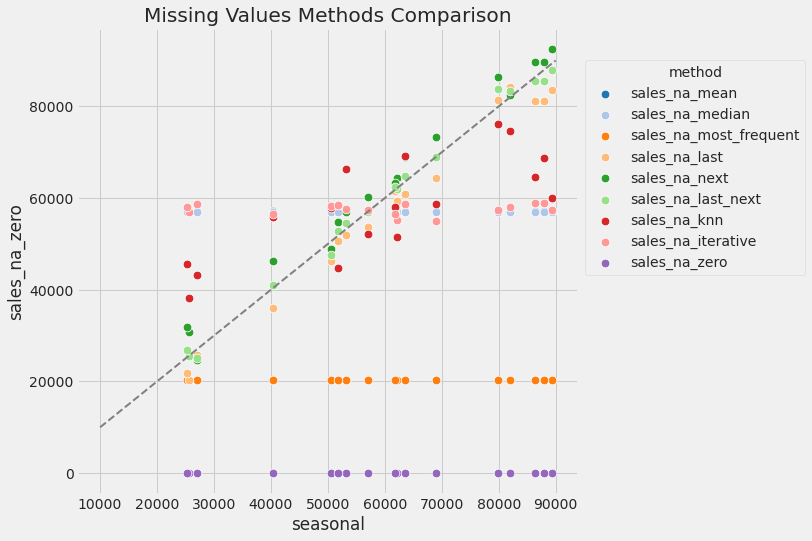

In [191]:
# Plot imputation methods 
fig, ax = plt.subplots(figsize=(8, 8))

for i, col in enumerate(seasonal.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='seasonal',
        y=col,
        data=seasonal.query('sales_na.isnull().values'),
        color=sns_c[i],
        label=col,
        s=75,
        ax=ax
    )
    
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.7))
ax.set(title='Missing Values Methods Comparison')
ax.plot([10000, 90000], [10000,90000], ls="--", lw=2, c='0.5')
# ax.axline(xy1=(10000, 10000), slope=1, color='gray', linestyle='--') # For some reason this wasn't working so I used ax.plot above

[(0.0, 101392.53839345077),
 Text(0, 0.5, 'Sales($)'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, 'Missing Values Methods Comparison')]

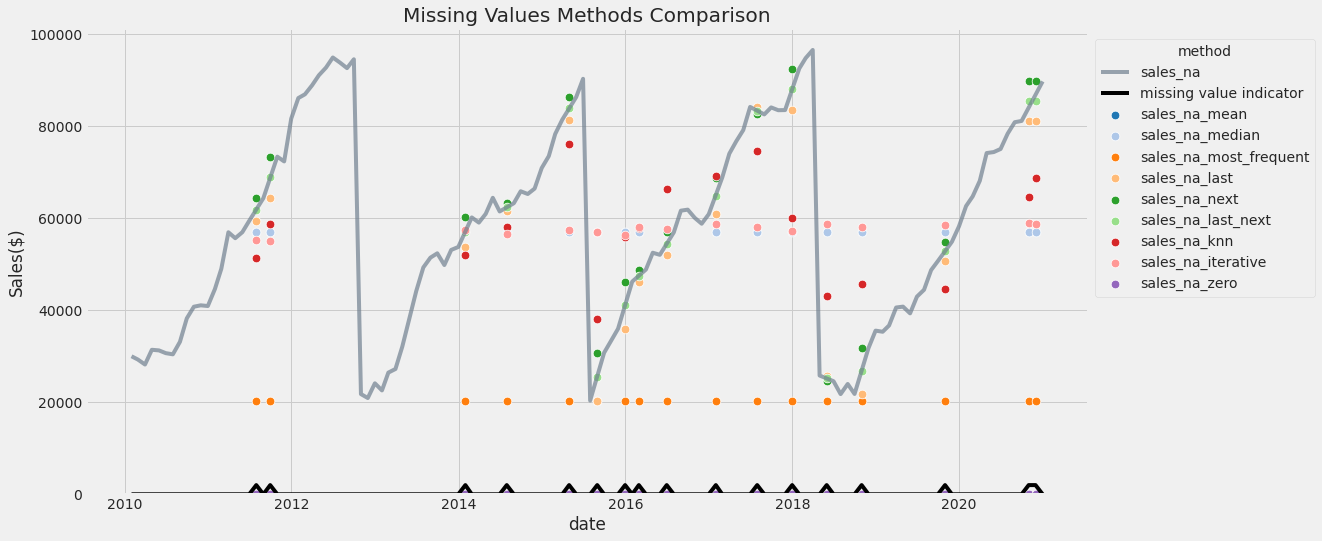

In [192]:
# Plot imputed missing values with true values
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(x='date', y='sales_na', data=seasonal, color='slategray', label='sales_na', alpha=0.7, ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=seasonal, color='black', label='missing value indicator',ax=ax)

for i, col in enumerate(seasonal.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='date',
        y=col,
        data=seasonal.query('sales_na.isnull().values'),
        color=sns_c[i],
        label=col,
        s=75,
        ax=ax
    )
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.7))
ax.set(title='Missing Values Methods Comparison', xlabel='date', ylabel='Sales($)', ylim=(0, None))

[Text(0, 0.5, ''),
 Text(0.5, 0, 'method'),
 Text(0.5, 1.0, 'Imputation Methods MAE')]

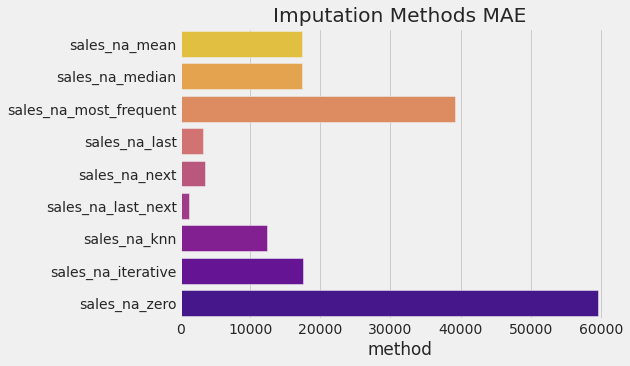

In [193]:
# Calculate and plot mean absolute error (MAE) by method
mae_dict = {}

for col in seasonal.filter(regex='sales_na_').columns:
    mae_dict[col] = mean_absolute_error(
        y_true=seasonal.query('sales_na.isnull().values')['seasonal'], 
        y_pred=seasonal.query('sales_na.isnull().values')[col]
    )

fig, ax = plt.subplots(figsize=(7, 5))

pd.DataFrame.from_dict(mae_dict, orient='index', columns=['mae']) \
            .reset_index(drop=False) \
            .pipe((sns.barplot, 'data'),
                   y='index', 
                   x='mae',
                   palette='plasma_r',
                   ax=ax
             )
ax.set(title='Imputation Methods MAE', xlabel='method', ylabel='')

In [194]:
# Sorted MAE values
seasonal_mae = pd.DataFrame.from_dict(mae_dict, orient='index', columns=['seasonal']).sort_values('seasonal')
seasonal_mae

,seasonal
sales_na_last_next,1303.162848
sales_na_last,3291.006754
sales_na_next,3528.595505
sales_na_knn,12351.475490
sales_na_mean,17337.215779
sales_na_median,17357.361942
sales_na_iterative,17497.834688
sales_na_most_frequent,39205.147259
sales_na_zero,59578.012696


For seasonal, the mean of forward and back fill performs the best. Median, mean, and iterative imputations perform poorly. 

## 5. Compare

Text(0.5, 1.0, 'MAE by Imputation Method and Trend')

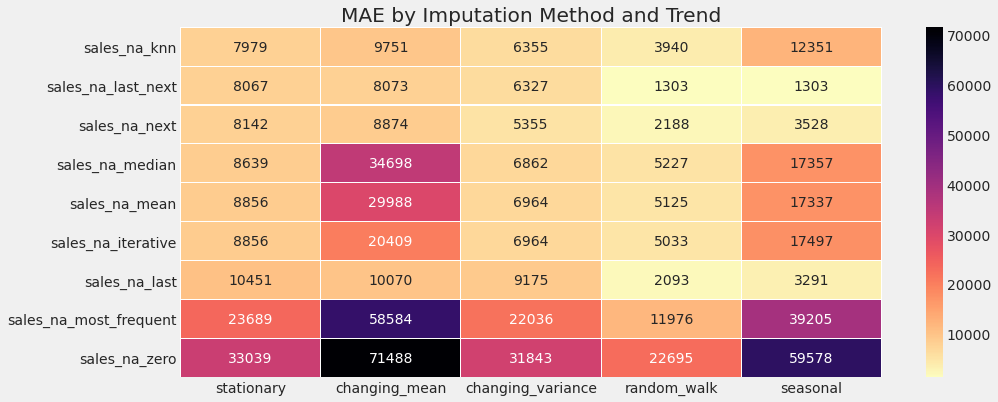

In [195]:
# Concatenate MAEs into one dataframe
all_mae = (pd.concat([stationary_mae, changing_mean_mae, changing_variance_mae, random_walk_mae, seasonal_mae], axis=1, ignore_index=False)).astype(int)

# Plot MAEs as heatmap
fig, ax = plt.subplots(figsize=(14,6))
sns.heatmap(all_mae, cmap='magma_r', linewidth=0.1, annot = True, fmt='g') 
ax.set_title('MAE by Imputation Method and Trend')

In summary, according to MAE:
- Mean of forward and back fill performs best for changing mean, random walk, and seasonal series
- Back fill performs best for a changing variance series
- KNN performs best for a stationary series
- Mean and median aren't appropriate for changing mean and seasonal series, however they can be used for a stationary series
- Most frequent and zeroes performed poorly for all series

We've generated random missing values to test out how different fill methods perform in different time series trends. In reality, when data includes missing values, it's important to understand the context and problem you're trying to solve, how the data is collected and study design, where the missing data came from (e.g., random, business holidays, non-response, etc.), and how we could expect missing values in the future. If splitting into train and test sets, mean or median imputation should be applied to the training set (not the entire data set). Additionally, back fill is not always possible if the missing value is that last data point. For seasonal series, it works best to de-seasonalize, impute the data, and re-seasonalize. 

## 6. Resources

[Handle Missing Values in Time Series](https://www.kaggle.com/juejuewang/handle-missing-values-in-time-series-for-beginners)

[What to do about missing values in time series data](https://gking.harvard.edu/files/pr.pdf)

[Stackexchange](https://quant.stackexchange.com/questions/41683/filling-a-few-missing-data-in-time-series)

[Pandas Interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)

[Berlin Time Series Analysis meetup](https://github.com/Anna-Barnett/btsa/blob/master/python/fundamentals/notebooks/eda_part_1_viz_and_missing_values.ipynb)

[Datacamp Time Series](https://learn.datacamp.com/skill-tracks/time-series-with-python)